# Cross Entropy

设事件 $X$ 发生的概率为 $P(X)$，从直觉出发，概率越小，事件发生的“惊喜”程度越大，惊喜程度可以用 $\frac{1}{P(x)}$ 衡量。

取对数，则惊喜程度可以定义为：

$$
\log(\frac{1}{P(x)}) = -\log(P(x))
$$

确定性事件（概率为1）的惊喜度为 0；对于不同独立事件，上式定义的惊喜度可以增加。

信息熵：真实概率分布下，惊喜程度的期望。

$$
H(P) = -\int_{x} P(x) \log(P(x)) \ dx
$$

交叉熵：考虑真实概率分布 $P$ 和预测概率分布 $Q$，预测事件的惊喜程度在真实概率分布下的期望即为交叉熵：

$$
H(P, Q) = -\int_{x} P(x) \log(Q(x)) \ dx
$$

KL 散度，交叉熵 - 真实概率分布信息熵：

$$
KL(P, Q) = H(P, Q) - H(P) = -\int_{x} P(x) \log(\frac{P(x)}{Q(x)}) \ dx
$$


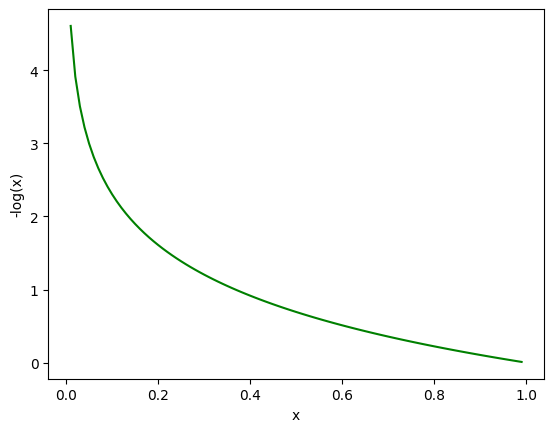

In [1]:
import matplotlib.pyplot as plt
import torch

x = torch.arange(0, 100) / 100.0  # probabiliy [0, 1]
plt.plot(x.tolist(), (-x.log()).tolist(), '-g', label="-log(x)")
plt.xlabel('x')
plt.ylabel('-log(x)')  # “surpriseness”
plt.show()

In [2]:
# 计算两个离散概率分布的交叉熵
p = torch.tensor([0.2, 0.7, 0.1])  # 真实概率分布
q = torch.tensor([0.3, 0.4, 0.3])  # 预测概率分布
ce = -p * q.log()
print(ce)
print(ce.sum())

tensor([0.2408, 0.6414, 0.1204])
tensor(1.0026)


In [3]:
# 假设预测分布接近真实分布
q = torch.tensor([0.2, 0.6, 0.2])  # 预测概率分布
ce = -p * q.log()
print(ce)
print(ce.sum())
# 交叉熵减小了

tensor([0.3219, 0.3576, 0.1609])
tensor(0.8404)


In [4]:
# 考虑真实分布是 one-hot 标签形式
p = torch.tensor([0.0, 1.0, 0.0])  # 真实概率分布, one-hot 标签
q = torch.tensor([0.3, 0.4, 0.3])  # 预测概率分布
ce = -p * q.log()
print(ce)
print(ce.sum())
print(-q.log())
# 可以看到，直接取真实标签在 -log(q) 上对应的值就是交叉熵的值

tensor([0.0000, 0.9163, 0.0000])
tensor(0.9163)
tensor([1.2040, 0.9163, 1.2040])


In [5]:
import torch.nn.functional as F

def calculate_ce_loss(logits, labels):
    """
    计算交叉熵损失
    logits: (batch_size, num_cls)
    labels: (batch_size, )
    """
    # 确保labels是torch.long类型
    labels = labels.long()

    # 计算负对数似然 (negative log likelihood)
    # log_softmax 数值更稳定，直接算 softmax 可能会导致数值溢出
    log_probs = F.log_softmax(logits, dim=-1)

    # 从 log_probs 中提取真实标签对应的对数概率
    nll_loss = -log_probs.gather(dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    # 等价于:
    # batch_size = labels.shape[0]
    # idx = torch.arange(0, batch_size)
    # nll_loss = -log_probs[idx, labels]

    # 对整个 batch 取平均
    return nll_loss.mean()

logits = torch.tensor([[0.2, 0.8], [0.6, 0.4]])
labels = torch.tensor([0, 1])

ce = calculate_ce_loss(logits, labels)
print(ce)
ce_loss_torch = torch.nn.CrossEntropyLoss()(logits, labels)
print(ce_loss_torch)

tensor(0.9178)
tensor(0.9178)


# Softmax

把 logits 向量归一化到概率分布向量

$$
Softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{d}e^{x_j}}
$$

## 减常数 C 避免数值溢出

exp() 容易指数爆炸溢出，一般可以先将 logits 向量减去一个常量，比如 logits 中的最大值:

$$
Softmax(x_i) = \frac{e^{x_i - C}}{\sum_{j=1}^{d}e^{x_j - C}}
$$

## Log Softmax

很多时候我们都需要对 logits 计算 log softmax 的值，但注意 log 函数在 0 点会取到 -inf ，导致数据溢出，我们可以直接计算 log softmax 值：

$$
\begin{aligned}
log(Softmax(x_i)) &= log(\frac{e^{x_i - C}}{\sum_{j=1}^{d}e^{x_j - C}}) \\
&= (x_i - C) - log(\sum_{j=1}^{d}e^{x_j - C})
\end{aligned}
$$

此时 $log(\sum_{j=1}^{d}e^{x_j - C})$ 不会溢出，这种方式计算的 log softmax (log probs) 也不会溢出。

我们可以通过 softmax 把 log probs 转回 probs :

$$
Softmax(x_i) = \frac{e^{log \ probs (i)}}{\sum_{j=1}^{d}e^{log \ probs (j)}}
$$


In [6]:
def safe_softmax(logits):
    # logits shape [batch_size, dim]
    logits_max, _ = logits.max(dim=-1)
    logits = logits - logits_max.unsqueeze(1) 
    logits = logits.exp()
    logits_sum = logits.sum(-1, keepdim = True)
    prob = logits / logits_sum
    return prob.abs()


def log_softmax(logits, recover_prob=False):
    logits_max, _ = logits.max(dim=-1)
    safe_logits = logits - logits_max.unsqueeze(1)
    exp_logits = safe_logits.exp()
    exp_logits_sum = exp_logits.sum(-1, keepdim=True)
    log_probs = (logits - logits_max.unsqueeze(1)) - exp_logits_sum.log()

    if recover_prob is True:
        exp_log_probs = log_probs.exp()
        probs = exp_log_probs / exp_log_probs.sum(-1, keepdim=True)
        return probs, log_probs

    return log_probs

logits = torch.tensor([[10, 2, 10000, 4]], dtype=torch.float32)
probs = safe_softmax(logits)
print(probs)
print('Directly computed log softmax(i.e. lob probs): ')
print(probs.log())

recovered_probs, log_probs = log_softmax(logits, recover_prob=True)
print('Log softmax log probs:')
print(log_probs)
print('recovered_probs:')
print(recovered_probs)
print(safe_softmax(log_probs))

print('torch.nn.functional.log_softmax(logits): ')
print(torch.nn.functional.log_softmax(logits, dim=-1))

tensor([[0., 0., 1., 0.]])
Directly computed log softmax(i.e. lob probs): 
tensor([[-inf, -inf, 0., -inf]])
Log softmax log probs:
tensor([[-9990., -9998.,     0., -9996.]])
recovered_probs:
tensor([[0., 0., 1., 0.]])
tensor([[0., 0., 1., 0.]])
torch.nn.functional.log_softmax(logits): 
tensor([[-9990., -9998.,     0., -9996.]])


# Perplexity Metric of Language Model

语言模型对文本的困惑度（Perplexity），即模型对真实文本的“惊讶程度”，越低表示文本越流畅（公式：`exp(NLL)`，NLL为负对数似然）

In [7]:
def CE_loss(logits, labels):
    """
    计算语言模型 next token prediction 输出的交叉熵损失
    logits: (batch_size, seq_len, vocab_size)
    labels: (batch_size, seq_len)
    返回:
    - token级平均损失: (batch_size, seq_len)
    - sequence级平均损失: (batch_size,)
    """
    # 计算负对数似然 (negative log likelihood)
    log_probs = F.log_softmax(logits, dim=-1)  # 先计算log softmax
    nll_loss = -log_probs.gather(dim=-1, index=labels.long().unsqueeze(-1)).squeeze(-1)
    
    # nll_loss, average token loss, shape (batch_size, seq_len)

    # 计算每个sequence的平均损失
    seq_loss = nll_loss.mean(dim=-1)  # (batch_size, )

    return nll_loss, seq_loss


def calculate_perplexity(loss):
    """
    从交叉熵损失计算困惑度
    loss: 每个 seq 的交叉熵损失值, (batch_size,)
    """
    # batch 维度取 mean
    max_loss = 50  # avoid inf
    clipped_loss = torch.clamp(loss, max=max_loss)
    return clipped_loss.exp().mean()

labels = torch.tensor([[0, 1, 2]], dtype=torch.float32)

# logits1 is more accurate
logits1 = torch.tensor([[[0.8, 0.1, 0.1],
                         [0.3, 0.5, 0.2],
                         [-100, 0, 3]]], dtype=torch.float32)

logits2 = torch.tensor([[[0.0, 20, 0.1],
                         [1.2, 0.5, 4.3],
                         [1000, 0, 3]]], dtype=torch.float32)

nll_loss1, seq_loss1 = CE_loss(logits1, labels)
nll_loss2, seq_loss2 = CE_loss(logits2, labels)
print(nll_loss1, seq_loss1)
print(nll_loss2, seq_loss2)

ppl1 = calculate_perplexity(seq_loss1)
ppl2 = calculate_perplexity(seq_loss2)
print(ppl1)  # logits1 has lower ppl
print(ppl2)

tensor([[0.6897, 0.9398, 0.0486]]) tensor([0.5594])
tensor([[ 20.0000,   3.8652, 997.0000]]) tensor([340.2884])
tensor(1.7496)
tensor(5.1847e+21)


# Softmax Cross Entropy 求导

对于多分类问题，Softmax函数将模型输出转换为概率分布：

$$
y_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}} \quad \text{其中} \quad i = 1,2,...,C
$$

其中：
- $C$ 是类别总数
- $z_i$ 是第 i 个类别的logit值（softmax层的输入）
- $y_i$ 是第 i 个类别的预测概率

Softmax的导数分为两种情况 (用复合函数求导法则推一下，h(x) = f(x)/g(x))：

1. 当对同一位置求导时（i = j）：

$$
\frac{\partial y_i}{\partial z_j} = y_i(1 - y_j)
$$

2. 当对不同位置求导时（i ≠ j）：

$$
\frac{\partial y_i}{\partial z_j} = -y_i y_j
$$

矩阵形式表示:

$$
\frac{\partial \mathbf{y}}{\partial \mathbf{z}} = \text{diag}(\mathbf{y}) - \mathbf{y}^T \mathbf{y}
$$


交叉熵损失函数定义

给定：
- 真实标签的one-hot编码 $\mathbf{p} = [p_1, p_2, ..., p_C]$
- 预测概率分布 $\mathbf{q} = [q_1, q_2, ..., q_C]$

交叉熵损失为：

$$
H(\mathbf{p}, \mathbf{q}) = -\sum_{i=1}^C p_i \log q_i
$$

交叉熵对softmax输出的导数

$$
\frac{\partial H}{\partial q_i} = -\frac{p_i}{q_i}
$$

## Softmax + Cross-Entropy 联合求导


前向计算路径:

$$
\text{logits} \ (z) \xrightarrow{\text{softmax}} \text{probs} \ (q) \xrightarrow{\text{CE}} \text{loss} \ (H)
$$

反向求导步骤:

根据链式法则：
$$
\frac{\partial H}{\partial z_j} = \sum_{i=1}^C \frac{\partial H}{\partial q_i} \cdot \frac{\partial q_i}{\partial z_j}
$$

其中：
- $\frac{\partial H}{\partial q_i} = -\frac{p_i}{q_i}$ （交叉熵对softmax输出的导数）
- $\frac{\partial q_i}{\partial z_j}$ 是softmax对logits的Jacobian矩阵

展开计算 

将两部分导数代入：
$$
\frac{\partial H}{\partial z_j} = \underbrace{\left(-\frac{p_j}{q_j}\right) \cdot q_j(1-q_j)}_{\text{当 } i=j} + \sum_{i \neq j} \underbrace{\left(-\frac{p_i}{q_i}\right) \cdot (-q_i q_j)}_{\text{当 } i \neq j}
$$

化简后：
$$
= -p_j (1-q_j) + \sum_{i \neq j} p_i q_j = q_j - p_j
$$

即 softmax cross entropy 直接对 logits 求导，得到了非常简单的形式


**为什么能直接跳过中间步骤？**

1. 数学巧合
   交叉熵的梯度 $\frac{\partial H}{\partial q_i} = -\frac{p_i}{q_i}$ 与 softmax 的 Jacobian 矩阵相乘后，所有中间项完美抵消，最终得到极其简洁的形式 $q_j - p_j$。
2. 物理意义
   梯度直接反映了预测概率 $q_j$ 与真实标签 $p_j$ 的差异，这与直觉一致：
   - 当 $q_j > p_j$（预测过度自信）：梯度为正，需要降低该logit
   - 当 $q_j < p_j$（预测不足）：梯度为负，需要增加该logit

**工程实现中的注意事项**

不要分开实现

```python
# 错误做法（数值不稳定且低效）
q = softmax(z)
loss = cross_entropy(q, p)
grad = ...  # 手动链式求导
```

应该直接使用联合函数
```python
# PyTorch（推荐）
loss = F.cross_entropy(z, targets)  # z是logits，targets是类别索引

# TensorFlow
loss = tf.nn.softmax_cross_entropy_with_logits(labels=p, logits=z)
```

这些函数内部：
 - 自动处理softmax的数值稳定性（如减去最大值）
 - 直接计算联合梯度 $q_j - p_j$，避免中间矩阵运算


In [8]:
# 随机生成logits和标签
logits = torch.randn(1, 5, requires_grad=True)  # batch_size=1, num_classes=5
labels = torch.tensor([2])  # 第3个类别（从0开始）

# 框架自动计算
loss = F.cross_entropy(logits, labels)
loss.backward()
auto_grad = logits.grad.clone()

# 手动计算
probs = F.softmax(logits, dim=1)
target_probs = torch.zeros_like(probs)
target_probs[0, labels.item()] = 1
manual_grad = probs - target_probs

# 比较结果
print(torch.allclose(auto_grad, manual_grad))  # 应输出True

True
